In [1]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 69.5 MB/s eta 0:00:00


In [2]:
import cv2
import numpy as np
import pandas as pd
import os
import glob
import math
from skimage.filters import roberts, sobel, scharr, prewitt
from scipy import ndimage as nd
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage import io
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sklearnPCA
from matplotlib import pyplot as plt
from skimage.feature import greycomatrix, greycoprops
import io
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima.arima import auto_arima
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import autocorrelation_plot
import seaborn as sn
import time

In [3]:
sn.set()
sn.set_palette("crest")

In [4]:
start_time = time.time()

## Reading extracted feature files and merging

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
Normal1 = pd.read_csv('/content/drive/MyDrive/UOM/FYP/Colab/Data_For_Journal/June2023/floodLargeDataset1.csv')
Normal2 = pd.read_csv('/content/drive/MyDrive/UOM/FYP/Colab/Data_For_Journal/June2023/floodLargeDataset2.csv')
Normal3 = pd.read_csv('/content/drive/MyDrive/UOM/FYP/Colab/Data_For_Journal/June2023/floodLargeDataset3.csv')
Normal4 = pd.read_csv('/content/drive/MyDrive/UOM/FYP/Colab/Data_For_Journal/June2023/floodLargeDataset4.csv')
Anomaly = pd.read_csv('/content/drive/MyDrive/UOM/FYP/Colab/Data_For_Journal/June2023/floodLargeDataset5.csv')

In [7]:
def merge(frames):
    result = pd.concat(frames, ignore_index=True, sort=False)
    return result

In [8]:
frames = [Normal1, Normal2, Normal3, Normal4, Anomaly]
full_featureset = merge(frames)
full_featureset.head(5)

,Unnamed: 0,Gray Level Images,CannyEdge,EdgeRoberts,EdgeSobel,EdgeScharr,EdgePrewitt,StatMean,StatAvgContrast,StatSkewness,...,GB67,GB68,GB69,GB70,GB71,GLCM_Diss_similarity,GLCM_Correlation,GLCM_Homogeneity,GLCM_Energy,GLCM_Contrast
0,0,1,23.255469,0.036038,0.046205,0.046728,0.045550,99.182439,1162.732749,-0.911304,...,120.245399,0.0,0.0,163.497509,161.931615,19.472719,0.623675,0.095826,0.024885,860.321912
1,1,2,23.255469,0.036038,0.046205,0.046728,0.045550,99.182439,1162.732749,-0.911304,...,120.245399,0.0,0.0,163.497509,161.931615,19.472719,0.623675,0.095826,0.024885,860.321912
2,2,3,23.589714,0.036294,0.046493,0.047022,0.045831,99.175938,1165.483924,-0.907445,...,120.236424,0.0,0.0,163.483003,161.916910,19.570386,0.622034,0.094453,0.024504,866.149175
3,3,4,23.589714,0.036294,0.046493,0.047022,0.045831,99.175938,1165.483924,-0.907445,...,120.236424,0.0,0.0,163.483003,161.916910,19.570386,0.622034,0.094453,0.024504,866.149175
4,4,5,23.589714,0.036294,0.046493,0.047022,0.045831,99.175938,1165.483924,-0.907445,...,120.236424,0.0,0.0,163.483003,161.916910,19.570386,0.622034,0.094453,0.024504,866.149175


*   No. Of Normal images = 2000
*   No. Of Anomaly images = 500
*   Training set size = 1750 (70%)
*   Test set size = 750

In [9]:
anomaly_image = int(input("The image (number) at which anomaly occurs in the dataset: "))
split_percentage = int(input("Percentage at which the dataset should be split: "))
dataset_length = int(input("Size of the dataset (no. of images): "))

The image (number) at which anomaly occurs in the dataset: 2000
Percentage at which the dataset should be split: 70
Size of the dataset (no. of images): 2500


In [10]:
full_featureset_indexes = []
for i in range(len(full_featureset)):
  full_featureset_indexes.append(i+1)

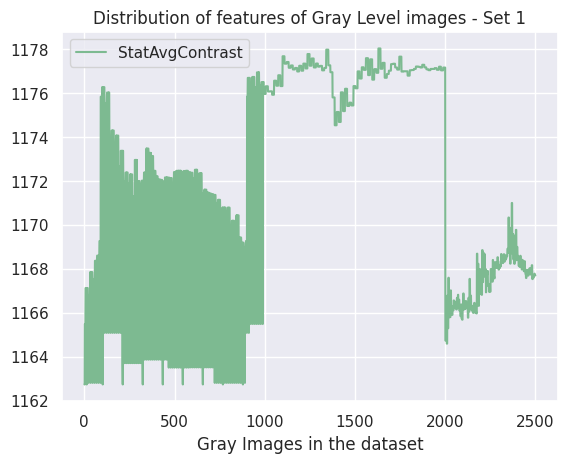

In [11]:
plt.plot(full_featureset_indexes, full_featureset['StatAvgContrast'], label="StatAvgContrast")
plt.xlabel('Gray Images in the dataset')
plt.title('Distribution of features of Gray Level images - Set 1')
plt.legend()
plt.show()

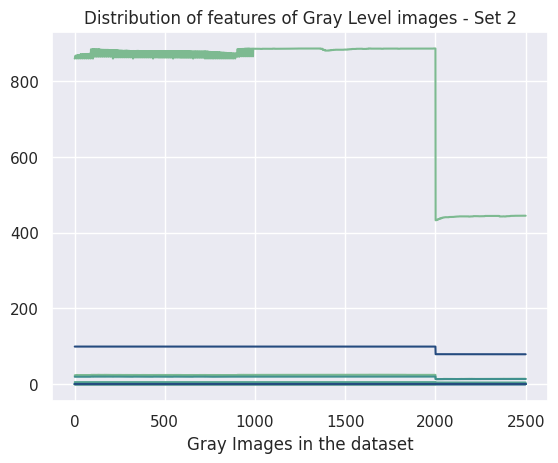

In [12]:
plt.plot(full_featureset_indexes, full_featureset['CannyEdge'], label="CannyEdge")
plt.plot(full_featureset_indexes, full_featureset['EdgeRoberts'], label="EdgeRoberts")
plt.plot(full_featureset_indexes, full_featureset['EdgeSobel'], label="EdgeSobel")
plt.plot(full_featureset_indexes, full_featureset['EdgeScharr'], label="EdgeScharr")
plt.plot(full_featureset_indexes, full_featureset['EdgePrewitt'], label="EdgePrewitt")
plt.plot(full_featureset_indexes, full_featureset['StatMean'], label="StatMean")
plt.plot(full_featureset_indexes, full_featureset['StatSkewness'], label="StatSkewness")
plt.plot(full_featureset_indexes, full_featureset['StatKurtosis'], label="StatKurtosis")

plt.plot(full_featureset_indexes, full_featureset['GLCM_Diss_similarity'], label="GLCM_Diss_similarity")
plt.plot(full_featureset_indexes, full_featureset['GLCM_Correlation'], label="GLCM_Correlation")
plt.plot(full_featureset_indexes, full_featureset['GLCM_Homogeneity'], label="GLCM_Homogeneity")
plt.plot(full_featureset_indexes, full_featureset['GLCM_Energy'], label="GLCM_Energy")
plt.plot(full_featureset_indexes, full_featureset['GLCM_Contrast'], label="GLCM_Contrast")
plt.xlabel('Gray Images in the dataset')
plt.title('Distribution of features of Gray Level images - Set 2')
plt.show()


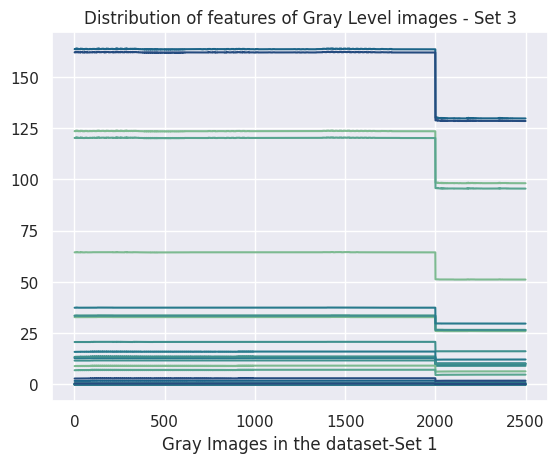

In [13]:
Gabor_plot_label_i = 0
for i in range(31):
  Gabor_plot_label = 'GB' + str(i)
  plt.plot(full_featureset_indexes, full_featureset[Gabor_plot_label], label=Gabor_plot_label)
  Gabor_plot_label_i += 1

plt.xlabel('Gray Images in the dataset-Set 1')
plt.title('Distribution of features of Gray Level images - Set 3')
plt.show()

In [14]:
colors = ["#2c3172"]
sn.set_palette(sn.color_palette(colors))

## PCA

In [15]:
pca_start_time = time.time()

In [16]:
#Standardize the data (The first step of PCA)

def standardizeData(featureset):
  X_std = StandardScaler().fit_transform(featureset)
  print(X_std.shape)
  return X_std

In [17]:
def getCovarianceMatrix(X_std):
   mean_vec= np.mean(X_std, axis=0)
   cov_mat = (X_std - mean_vec).T.dot((X_std-mean_vec)) / (X_std.shape[0]-1)
   print('Covariance matrix: \n%s' %cov_mat)
   return cov_mat

In [18]:
def performPCA(features):
    featureset = features
    featureset.drop(['Gray Level Images'], axis = 1, inplace = True)

    X_std = standardizeData(featureset)

    pca = sklearnPCA(n_components=2)
    # pca.fit_transform(featureset)
    principalComponents_features = pca.fit_transform(X_std)
    print('PCA Variance ratio: ', pca.explained_variance_ratio_)
    principal_features = pd.DataFrame(data=principalComponents_features, columns=['principal component 1',
                                                                                  'principal component 2'])
    principal_features.to_csv('drive/MyDrive/UOM/FYP/Colab/D_BD_PCAFeatures.csv')

    return principal_features

In [19]:
principal_features = performPCA(full_featureset)

(2500, 87)
PCA Variance ratio:  [0.86687611 0.03860493]


In [20]:
pca_end_time = time.time()

In [21]:
PCA1 = principal_features["principal component 1"]
PCA2 = principal_features["principal component 2"]

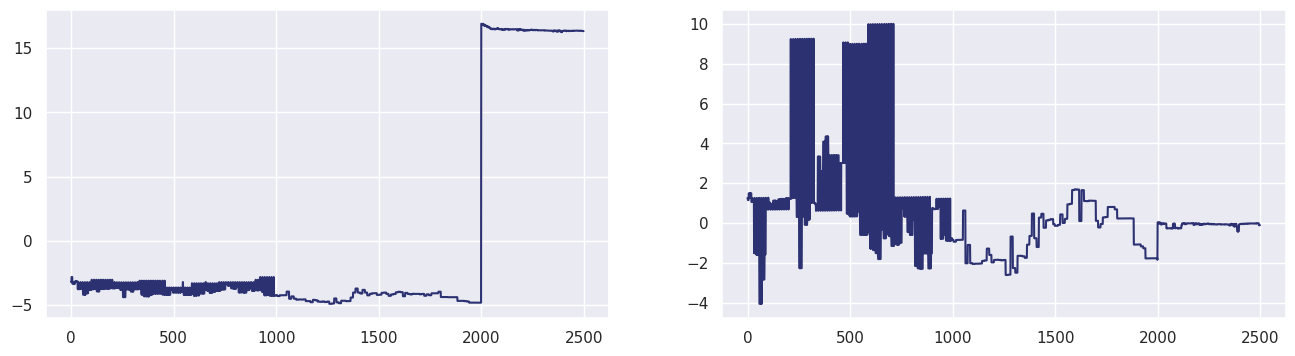

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(PCA1)
ax2.plot(PCA2)

ax1.figure.savefig('drive/MyDrive/UOM/FYP/Colab/Images/Images_For_Journal/Deforestation/BigDataset/PCA1.png')
ax2.figure.savefig('drive/MyDrive/UOM/FYP/Colab/Images/Images_For_Journal/Deforestation/BigDataset/PCA2.png')

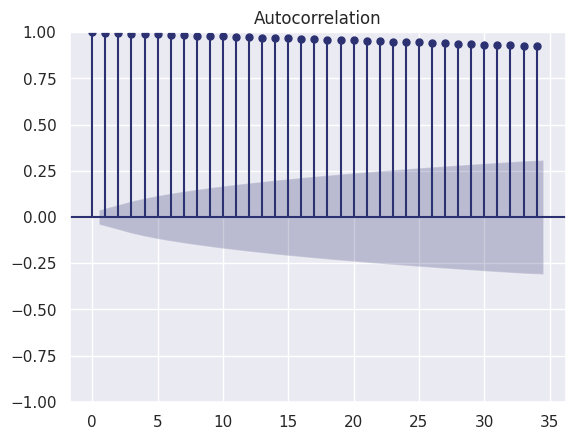

In [23]:
acf_plot = plot_acf(PCA1);
acf_plot.savefig('drive/MyDrive/UOM/FYP/Colab/Images/Images_For_Journal/Deforestation/BigDataset/ACFBeforeARIMA.png')

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


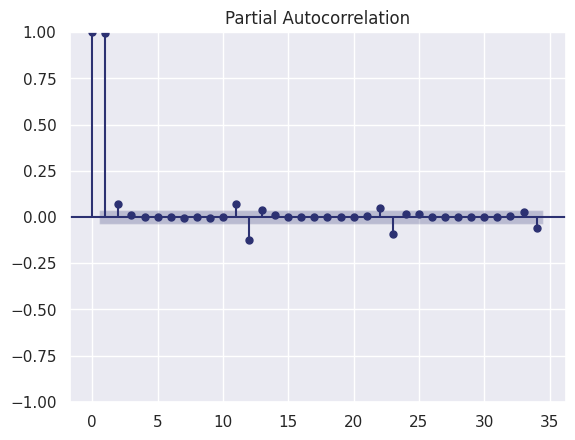

In [24]:
pacf_plot = plot_pacf(PCA1);
pacf_plot.savefig('drive/MyDrive/UOM/FYP/Colab/Images/Images_For_Journal/Deforestation/BigDataset/PACFBeforeARIMA.png')

## ARIMA

### Reading and splitting the dataset

In [25]:
file = pd.read_csv('/content/drive/MyDrive/UOM/FYP/Colab/D_BD_PCAFeatures.csv')
PCA1 = file["principal component 1"]

In [26]:
def splitDataset(dataset, split_percentage):
  size = int(dataset_length * (split_percentage/100))
  train, test = dataset[0:size], dataset[size:dataset_length]
  print(train.head(5))
  print(test.head(5))
  return train, test, size

In [27]:
train_set, test_set, split_image = splitDataset(PCA1, split_percentage)
train_set_length = len(train_set)
test_set_length = len(test_set)

0   -3.201680
1   -3.201684
2   -2.809003
3   -2.809007
4   -2.809011
Name: principal component 1, dtype: float64
1750   -4.227802
1751   -4.227806
1752   -4.227810
1753   -4.227814
1754   -4.227818
Name: principal component 1, dtype: float64


### ARIMA model training

In [28]:
arima_start_time = time.time()

In [29]:
def performARIMA(train_set):
  arima_result = auto_arima(train_set)
  print(arima_result)
  print("\n")
  print(arima_result.summary())

  result_string = str(arima_result)
  number_of_diffs = int(result_string[9])
  print("The number of differences needed to make the data stationary: ", number_of_diffs)

  return arima_result, number_of_diffs

In [30]:
arima_result, number_of_diffs = performARIMA(train_set)

 ARIMA(5,1,5)(0,0,0)[0]          


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1750
Model:               SARIMAX(5, 1, 5)   Log Likelihood                 512.031
Date:                Sun, 25 Jun 2023   AIC                          -1002.062
Time:                        18:52:03   BIC                           -941.928
Sample:                             0   HQIC                          -979.832
                               - 1750                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9070      0.026    -35.088      0.000      -0.958      -0.856
ar.L2         -0.9346      0.025    -37.738      0.000      -0.983      -0.886
ar.L3         -0

In [31]:
arima_end_time = time.time()

### Plotting Residuals

In [32]:
residuals = pd.DataFrame(arima_result.resid(), columns= ['resids'])

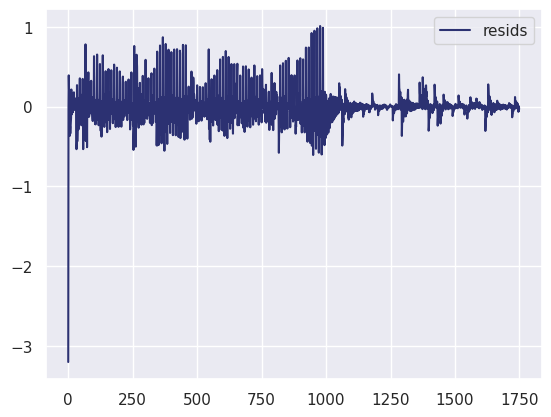

In [33]:
residuals.plot()
plt.show()

In [34]:
filtered_residuals = residuals[residuals.resids > -1.7]

In [35]:
filtered_twice_residuals = filtered_residuals[filtered_residuals.resids < 1.7]

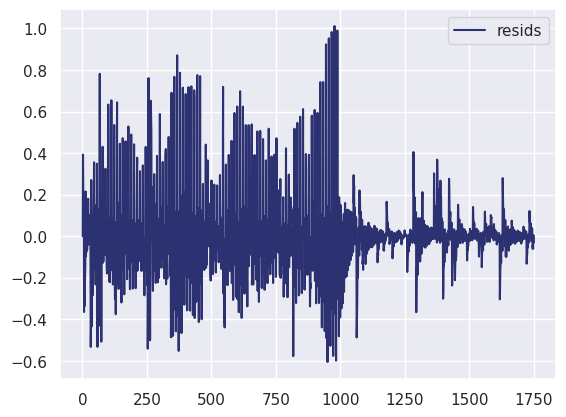

In [36]:
plt_resids = filtered_twice_residuals.plot()
plt_resids.figure.savefig('drive/MyDrive/UOM/FYP/Colab/Images/Images_For_Journal/Deforestation/BigDataset/ResidualsPlot.png')

<ipython-input-37-6ad9757c47d8>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  density_plot = sn.distplot(filtered_twice_residuals, kde=True)


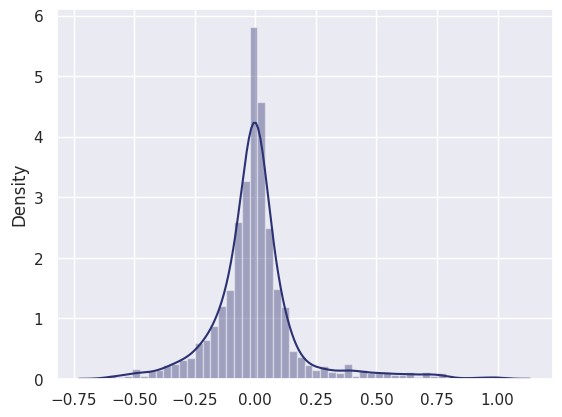

In [37]:
density_plot = sn.distplot(filtered_twice_residuals, kde=True)
density_plot.figure.savefig('drive/MyDrive/UOM/FYP/Colab/Images/Images_For_Journal/Deforestation/BigDataset/density_plot.png')

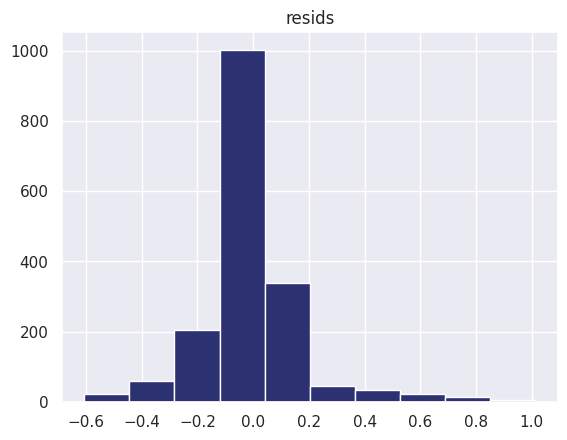

In [38]:
filtered_twice_residuals.hist()
plt.show()

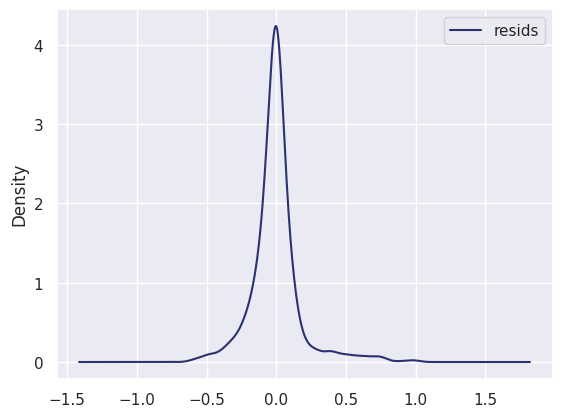

In [39]:
filtered_twice_residuals.plot(kind='kde')
plt.show()

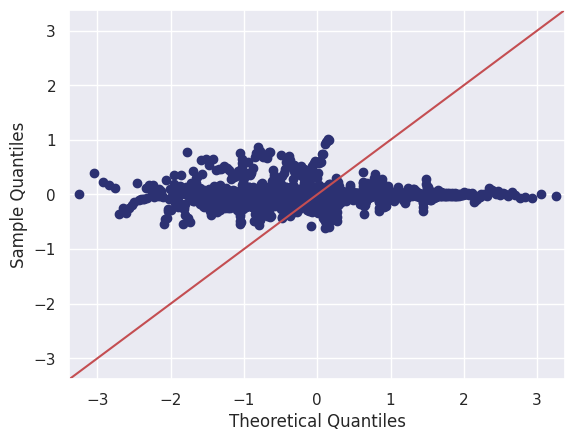

In [40]:
qqplot(filtered_twice_residuals, line='45')
plt.show()

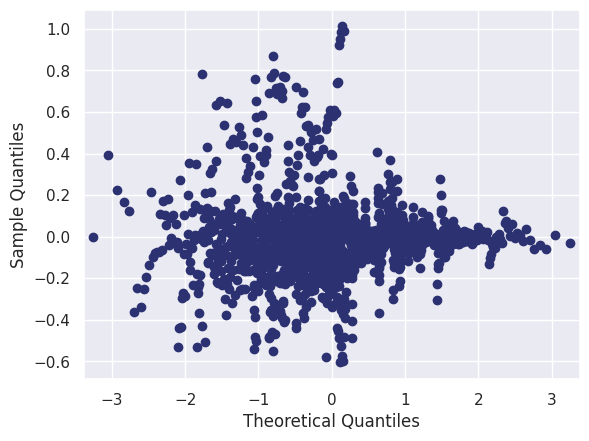

In [41]:
qqplot(filtered_twice_residuals)
plt.show()

In [42]:
from statsmodels.graphics.tsaplots import plot_acf

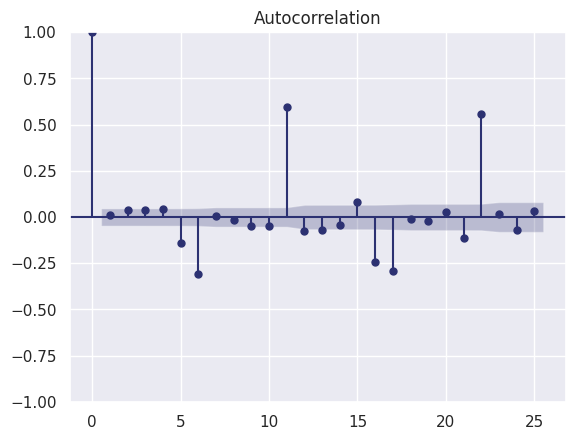

In [43]:
residuals_acf = plot_acf(filtered_twice_residuals, lags=25)
residuals_acf.savefig('drive/MyDrive/UOM/FYP/Colab/Images/Images_For_Journal/Deforestation/BigDataset/residuals_acf.png')

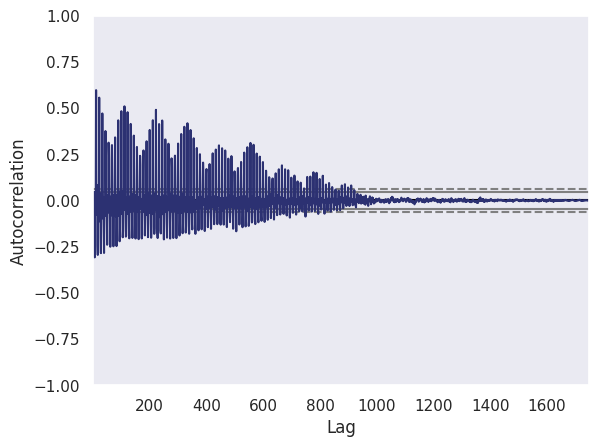

In [44]:
autocorrelation_plot(filtered_twice_residuals)
plt.show()

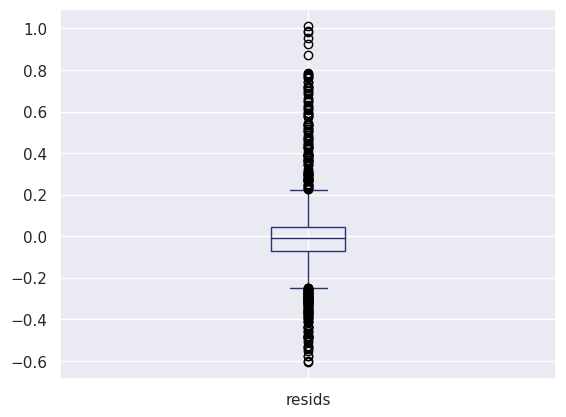

In [45]:
residuals_boxPlot = filtered_twice_residuals.plot.box(grid='True')
residuals_boxPlot.figure.savefig('drive/MyDrive/UOM/FYP/Colab/Images/Images_For_Journal/Deforestation/BigDataset/residuals_boxPlot.png')

### Residual Description

In [46]:
def calculateBoxPlotValues(residuals):
  residuals_description = residuals.describe()
  df_residuals_description = pd.DataFrame(residuals_description)
  min = float(df_residuals_description.loc["25%"]) - 1.5 * (float(df_residuals_description.loc["75%"])-float(df_residuals_description.loc["25%"])) #
  max = float(df_residuals_description.loc["75%"]) + 1.5 * (float(df_residuals_description.loc["75%"])-float(df_residuals_description.loc["25%"]))
  print("Minimum values is: ", min)
  print("Maximum values is: ",max)
  return max, min

In [47]:
boxPlotMax, boxPlotMin = calculateBoxPlotValues(filtered_twice_residuals)
anomalous_threshold = boxPlotMax

Minimum values is:  -0.2497799893306476
Maximum values is:  0.22375052116826155


## Forecasting

In [48]:
forecast_start_time = time.time()

In [49]:
def performForecasting(arima_result, test_set_length, test):
  forecast = arima_result.predict(test_set_length, alpha=0.05) # 95% conf
  print(forecast)
  fc_series = pd.Series(forecast, index=test.index)
  return fc_series

In [50]:
forecasted_series = performForecasting(arima_result, test_set_length, test_set)

1750   -4.203489
1751   -4.225900
1752   -4.197142
1753   -4.238480
1754   -4.211158
          ...   
2495   -4.215774
2496   -4.215774
2497   -4.215774
2498   -4.215774
2499   -4.215774
Length: 750, dtype: float64


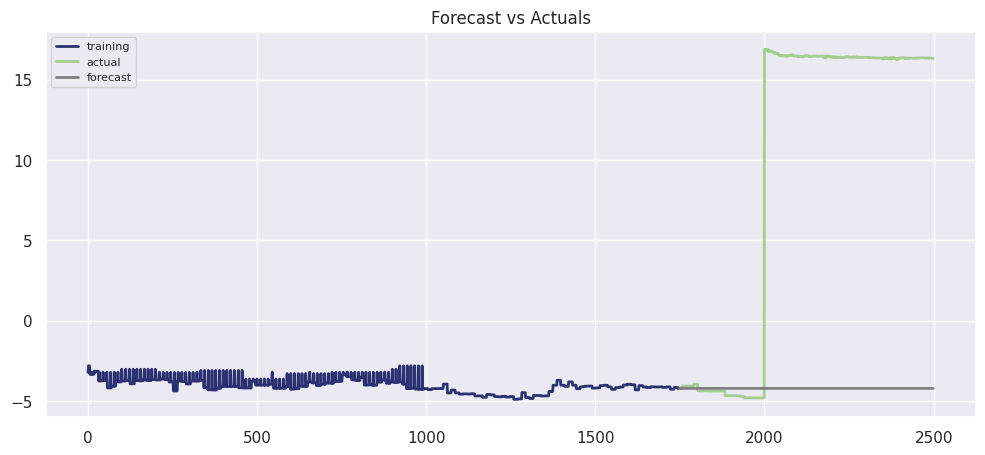

In [51]:
forecastPlot = plt.figure(figsize=(12,5), dpi=100)
# forecastPlot = plt.plot(train_set, label='training', color='mediumturquoise', linewidth=2)
forecastPlot = plt.plot(train_set, label='training', color="#2c3172", linewidth=2)
# forecastPlot = plt.plot(test_set, label='actual', color='springgreen', linewidth=2)
forecastPlot = plt.plot(test_set, label='actual', color="#a5cd90", linewidth=2)
forecastPlot = plt.plot(forecasted_series, label='forecast', color='grey', linewidth=2)
forecastPlot = plt.title('Forecast vs Actuals')
forecastPlot = plt.legend(loc='upper left', fontsize=8)
forecastPlot.figure.savefig('drive/MyDrive/UOM/FYP/Colab/Images/Images_For_Journal/Deforestation/BigDataset/forecastVSActualsPlotWithoutThreshold.png')

In [52]:
forecast_end_time = time.time()

## Binary Classification

In [53]:
classification_start_time = time.time()

Calculating the forecast errors using the forecasted series and the actual values of the test series

In [54]:
def calculateForecastErrors(fc_series, test, train_set_length):
  y_hat_values = []
  i = train_set_length
  print(i)
  for value in fc_series:
    y_hat = test[i] - value
    y_hat_values.append(y_hat)
    i = i + 1

  df_Forecasted_Series = pd.DataFrame(np.array(y_hat_values).astype(np.float), index = range(split_image, dataset_length), columns = ['Forecasted_Error'])
  return df_Forecasted_Series

In [55]:
df_Forecasted_Series = calculateForecastErrors(forecasted_series, test_set, train_set_length)

1750


<ipython-input-54-d059dc617e2a>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_Forecasted_Series = pd.DataFrame(np.array(y_hat_values).astype(np.float), index = range(split_image, dataset_length), columns = ['Forecasted_Error'])


In [56]:
def classification(df_Forecasted_Series, anomalous_threshold, anomaly_image):
  index = df_Forecasted_Series.index
  for i in index:
    error = df_Forecasted_Series["Forecasted_Error"].loc[i]
    #Classify residuals as normal/anomaly
    if (error>anomalous_threshold):
      df_Forecasted_Series.loc[i, 'Predicted_Class'] = "Anomaly"
    else:
      df_Forecasted_Series.loc[i, 'Predicted_Class'] = "Normal"

    #Set the actual class
    if(i>=anomaly_image):
      df_Forecasted_Series.loc[i, 'Actual_Class'] = "Anomaly"
    else:
      df_Forecasted_Series.loc[i, 'Actual_Class'] = "Normal"

  return df_Forecasted_Series

In [57]:
df_Forecasted_Series = classification(df_Forecasted_Series, anomalous_threshold, anomaly_image)

In [58]:
df_Forecasted_Series

,Forecasted_Error,Predicted_Class,Actual_Class
1750,-0.024313,Normal,Normal
1751,-0.001905,Normal,Normal
1752,-0.030668,Normal,Normal
1753,0.010666,Normal,Normal
1754,-0.016660,Normal,Normal
...,...,...,...
2495,20.540766,Anomaly,Anomaly
2496,20.539583,Anomaly,Anomaly
2497,20.539579,Anomaly,Anomaly
2498,20.539575,Anomaly,Anomaly


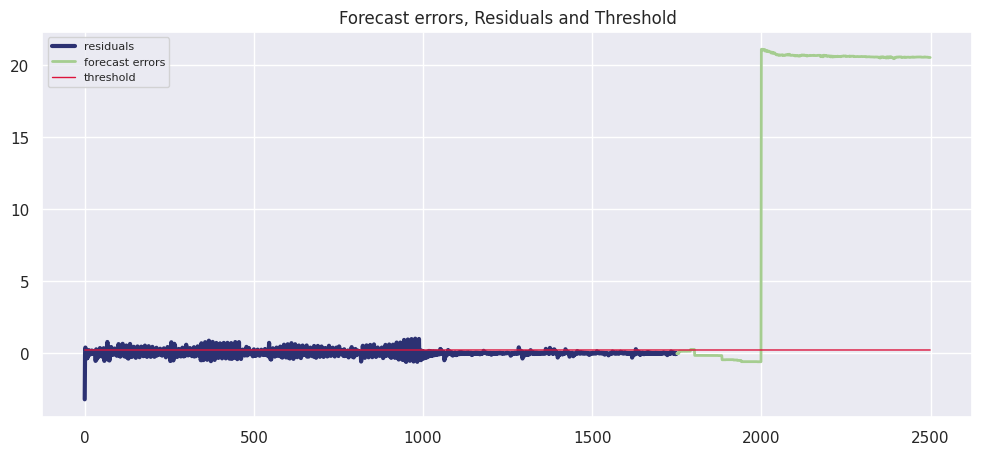

In [59]:
max_threshold_series = np.full((dataset_length,1), anomalous_threshold)
forecast_error_series = df_Forecasted_Series["Forecasted_Error"]
thresholdPlot = plt.figure(figsize=(12,5), dpi=100)
thresholdPlot = plt.plot(residuals, label='residuals', color= "#2c3172", linewidth=3)
thresholdPlot = plt.plot(forecast_error_series, label='forecast errors', color="#a5cd90", linewidth=2)
thresholdPlot = plt.plot(max_threshold_series, label='threshold', color='crimson', linewidth=1)
thresholdPlot = plt.title('Forecast errors, Residuals and Threshold')
thresholdPlot = plt.legend(loc='upper left', fontsize=8)
# plt.show()
thresholdPlot.figure.savefig('drive/MyDrive/UOM/FYP/Colab/Images/Images_For_Journal/Deforestation/BigDataset/BoxPlot_Forecast_Actuals_plotWithThreshold.png')

In [60]:
classification_end_time = time.time()

## Measuring Performance

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

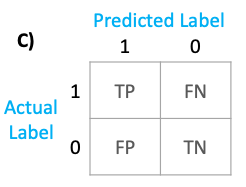

In [62]:
import seaborn as sn

In [63]:
def getConfusionPLot(df_Forecasted_Series):
  confusionMatrix = confusion_matrix(df_Forecasted_Series['Actual_Class'], df_Forecasted_Series['Predicted_Class'])
  print(confusionMatrix)

  sn.heatmap(confusionMatrix, annot=True, fmt='.2f', cmap='crest')

  return confusionMatrix

[[500   0]
 [ 12 238]]


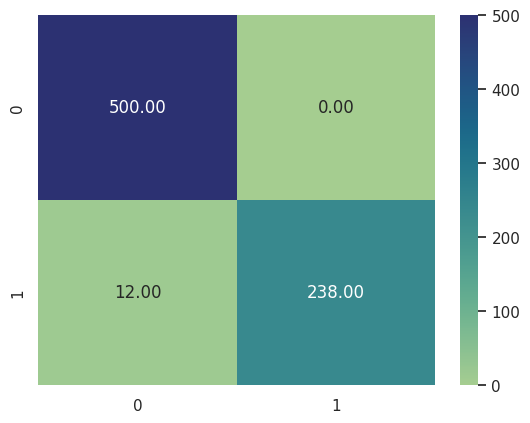

In [64]:
confusionMatrix = getConfusionPLot(df_Forecasted_Series)
plt.savefig('drive/MyDrive/UOM/FYP/Colab/Images/Images_For_Journal/Deforestation/BigDataset/boxPlotConfusionMatrix.png')

It is important to note that,


> our objective function = finding an anomaly

So, the positive class should favour it.


> Positive class = anomaly behaviour (0)


> Negative class = normal behaviour (1)








> ▶True positives => True label:Anomaly, Predicted label:Anomaly [0,0]


> ▶True negatives => True label:Normal, Predicted label:Normal [1,1]


> ▶False positives => True label:Normal, Predicted label:Anomaly [1,0]


> ▶False negatives => True label:Anomaly, Predicted label:Normal [0,1]

Original example for ravel() was,


> TN,FP,FN,TP = confusionmatrix.ravel()



In [65]:
def checkPerformance(confusionMatrix, test_set_length, dataset_length, anomaly_image, split_image):
  True_positives,False_negatives,False_positives,True_negatives = confusionMatrix.ravel()
  print("True positives: ", True_positives)
  print("True negatives: ", True_negatives)
  print("False positives: ", False_positives)
  print("False negatives: ", False_negatives)

  accuracy = (True_positives+True_negatives)/(True_positives+True_negatives+False_positives+False_negatives)
  print("accuracy: ", accuracy)
  sensitivity = True_positives/(True_positives+False_negatives) #Sn
  print("sensitivity: ", sensitivity)
  specificity = True_negatives/(True_negatives+False_positives) #Sp
  print("specificity: ", specificity)
  positive_predictive_value = True_positives/(True_positives+False_positives)
  print("positive_predictive_value: ", positive_predictive_value)
  negative_predictive_value = True_negatives/(True_negatives+False_negatives)
  print("negative_predictive_value: ", negative_predictive_value)
  precision = (True_positives+True_negatives)/(True_positives+True_negatives+False_positives+False_negatives)
  print("precision: ", precision)

  cc_numerator = True_positives*True_negatives - False_positives*False_negatives
  cc_denominator = math.sqrt(anomaly_image*(True_positives+False_positives)*abs((dataset_length-split_image)-anomaly_image)*(True_negatives+False_negatives))
  corr_coefficient = cc_numerator/cc_denominator
  print("corr_coefficient: ", corr_coefficient)

  anomalous_set_length = dataset_length - anomaly_image
  relationship_index = abs(specificity-sensitivity)/(specificity+sensitivity)
  P = specificity*(anomalous_set_length/test_set_length) + sensitivity*((test_set_length - anomalous_set_length)/test_set_length)
  OP = P-relationship_index
  print("OP:", OP)

  new_metric = math.sqrt((True_positives / (True_positives + False_negatives) )* (True_negatives /(True_negatives + False_positives)))
  print("New Metric: ", new_metric)

  f1_score = 2 * ((positive_predictive_value * sensitivity) / (positive_predictive_value + sensitivity))
  print("F1 Score: ", f1_score)

In [66]:
checkPerformance(confusionMatrix, test_set_length, dataset_length, anomaly_image, split_image)

True positives:  500
True negatives:  238
False positives:  12
False negatives:  0
accuracy:  0.984
sensitivity:  1.0
specificity:  0.952
positive_predictive_value:  0.9765625
negative_predictive_value:  1.0
precision:  0.984
corr_coefficient:  0.21560235388325424
OP: 0.9434098360655737
New Metric:  0.9757048734120374
F1 Score:  0.9881422924901185


In [67]:
classification_end_time = time.time()

In [68]:
end_time = time.time()

## Time Taken

Total time taken (excluding pre-processing and feature extraction) for the big dataset **(in seconds)**

In [69]:
total_time = end_time - start_time
total_time

237.13706636428833

Time taken for the PCA **(in seconds)**

In [70]:
time_PCA = pca_end_time - pca_start_time
time_PCA

0.3176236152648926

Time taken for ARIMA **(in seconds)**

In [71]:
time_arima = arima_end_time - arima_start_time
time_arima

68.86335182189941

Time taken for forecasting **(in seconds)**

In [72]:
time_forecast = forecast_end_time - forecast_start_time
time_forecast

0.5812175273895264

Time taken for the binary classification **(in seconds)**

In [73]:
time_classification = classification_end_time - classification_start_time
time_classification

1.222339153289795

## Classification with EVT

### Import necessary libraries

In [74]:
!pip install fitter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for fitter: filename=fitter-1.5.2-py3-none-any.whl size=25608 sha256=37c9d01b25433c2e851a7da48172ec5db33549069e927a406c8c56fd7bae29fb
  Stored in directory: /root/.cache/pip/wheels/eb/50/1d/6d8762c6a9a50d3668e53f98164ba13ca314827fb5ac7ebeaa
Successfully built fitter


In [75]:
from fitter import Fitter
from scipy.stats import gumbel_l
from scipy.stats import gumbel_r

In [76]:
evt_start_time = time.time()

### Threshold calculation using EVT

In [77]:
def anomaly_threshold_evt(residuals, confidence):


  #Transforming the residuals
  extrem_prob_residuals = np.exp(-np.exp(-residuals))

  #fitting to the curve
  f1 = Fitter(extrem_prob_residuals, distributions=['gumbel_l'], bins=45)
  f1.fit()
  params = f1.get_best()
  confidence =1-confidence
  t = gumbel_l.ppf(confidence, loc=params.get("gumbel_l").get("loc"), scale=params.get("gumbel_l").get("scale"))
  t = abs(t)
  #retransform
  threshold_val = np.log(-np.log(t))

  #print(threshold_val)

  return threshold_val

In [78]:
evt_threshold = anomaly_threshold_evt(np.array(filtered_twice_residuals), 0.95)

Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 100.69it/s]


In [79]:
evt_threshold

0.6860466756966305

In [80]:
evt_forecastedError_df = df_Forecasted_Series
evt_forecastedError_df = classification(evt_forecastedError_df, evt_threshold, anomaly_image)
evt_forecastedError_df

,Forecasted_Error,Predicted_Class,Actual_Class
1750,-0.024313,Normal,Normal
1751,-0.001905,Normal,Normal
1752,-0.030668,Normal,Normal
1753,0.010666,Normal,Normal
1754,-0.016660,Normal,Normal
...,...,...,...
2495,20.540766,Anomaly,Anomaly
2496,20.539583,Anomaly,Anomaly
2497,20.539579,Anomaly,Anomaly
2498,20.539575,Anomaly,Anomaly


[[500   0]
 [  0 250]]


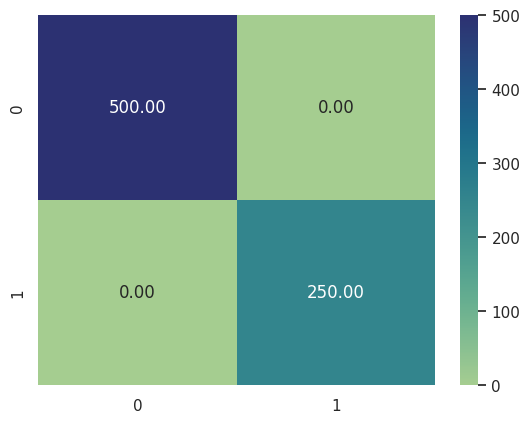

In [81]:
evt_confusionMatrix = getConfusionPLot(df_Forecasted_Series)
plt.savefig('drive/MyDrive/UOM/FYP/Colab/Images/Images_For_Journal/Deforestation/BigDataset/evt_confusionMatrix.png')

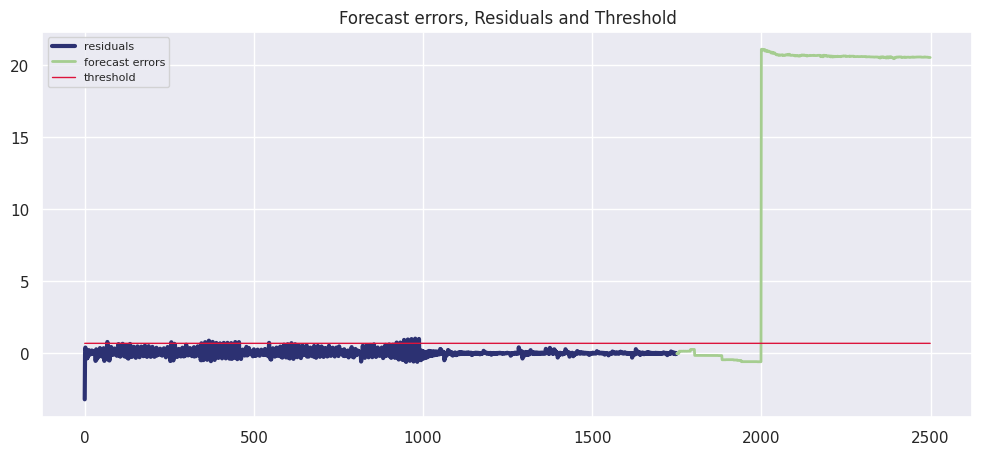

In [82]:
evt_max_threshold_series = np.full((dataset_length,1), evt_threshold)
forecast_error_series = df_Forecasted_Series["Forecasted_Error"]
thresholdPlot = plt.figure(figsize=(12,5), dpi=100)
thresholdPlot = plt.plot(residuals, label='residuals', color= "#2c3172", linewidth=3)
thresholdPlot = plt.plot(forecast_error_series, label='forecast errors', color="#a5cd90", linewidth=2)
thresholdPlot = plt.plot(evt_max_threshold_series, label='threshold', color='crimson', linewidth=1)
thresholdPlot = plt.title('Forecast errors, Residuals and Threshold')
thresholdPlot = plt.legend(loc='upper left', fontsize=8)
# plt.show()
thresholdPlot.figure.savefig('drive/MyDrive/UOM/FYP/Colab/Images/Images_For_Journal/Deforestation/BigDataset/EVT_Forecast_Actuals_plotWithThreshold.png')

In [83]:
checkPerformance(evt_confusionMatrix, test_set_length, dataset_length, anomaly_image, split_image)

True positives:  500
True negatives:  250
False positives:  0
False negatives:  0
accuracy:  1.0
sensitivity:  1.0
specificity:  1.0
positive_predictive_value:  1.0
negative_predictive_value:  1.0
precision:  1.0
corr_coefficient:  0.223606797749979
OP: 1.0
New Metric:  1.0
F1 Score:  1.0
